## Færdiggørelse af COVID-19 prognosen fra Statens Seruminstitut og Sundhedsstyrelsen 30. marts 2020

Statens prognose er overordnet beskrevet i notatet *COVID-19 i Danmark - Status ved indgang til 5. epidemiuge* 
(findes i kopi her: [Status_COVID19_femte_uge.pdf](Status_COVID19_femte_uge.pdf), ellers 
henvises til litteraturlisten i i [README.md](README.md)).

Her modellerer vi epidemikurven og den prognose, som behændigt er udeladt fra notatet.

Beskrivelsen af modellen starter i afsnit 4 om prognoser på side 22.

Vi forsøger at genskabe notatets model, der denne gang er lidt bedre beskrevet; bl.a. nævner de at det *er* en 
SIR-model.

### Hvor længe skal Danmark være lukket?
Dette svarer de ikke på - faktisk snakker de meget om "røde" og "grønne" kurver (den røde er den hurtige epidemi, hvor
sundhedsvæsenet bryder sammen på grund af overefterspørgsel, den grønne er en lavere, hvor behandlingsbehovet holder 
sig under sundhedsvæsenets kapacitet). 

Notatet nævner, at vi er på den "grønne kurve", men viser ikke prognosen. 

Lad os komme i gang. Først har vi brug for nogle databehandlingspakker:

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.integrate import odeint

import datetime
import collections

## Antagelser

### Epidemistarten
Notate nævner (p. 22), at der er påvist tilfælde af COVID-19 allerede i den første uge af marts. Epidemistartsdatoen 
er er således knapt to uger tidligere, end antaget i deres seneste notat.

In [113]:
EPIDEMI_START = datetime.date(2020,3,1)

## Befolkningsantagelser
Vi regner med 5,8 mio. personer i Danmark.
Kilde: [Danmarks Statistiks Folketal](https://www.dst.dk/da/Statistik/emner/befolkning-og-valg/befolkning-og-befolkningsfremskrivning/folketal).

In [114]:
# Total befolkning
BEFOLKNINGSTAL_DANMARK = 5_800_000

## SIR-modellen
[SIR-modellen](https://da.wikipedia.org/wiki/SIR-modellen) er en simpel infektionsmodel.

S, I, og R står for henholdsvis *Susceptible* (hvor man kan få sygdommen, som ikke har haft den endnu), 
*Infectuous* (hvor mange har den nu og kan smitte andre), og de 
*Recovered* (dem der ikke længere har sygdommen, både de helbredte og de døde).

Udviklingen over tid beskrives med nogle simple differentialligninger.

Modellen er også vist med kodeeksempler i [SciPython-bogen](https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/).
Disse danner udgangspunkt for nedenstående.


## Smitteantagelser
$\beta$ (beta) beskriver hvor smitsom sygdommen er.

$\gamma$ (gamma) beskriver hvor hurtigt folk holder op med at være smitsomme, det reciprokke af 
 hvor mange dage de smitter.

*Reproduktionstallet* $R_0$ (engelsk, "R-nought") angiver hvor mange andre en 
smittet person smitter.

I SIR-modellen kan det udtrykkes som:

$$R_0 = {\beta\over\gamma}$$

Bemærk, at $R_0$ ikke er det samme som værdien for $R$ (antal "recovered") til tiden $t=0$. 

### Norditalien
Notatet anvender Norditalien som sammenligning uden at angive parametrene, men 
i det foregående notatet har vi nogle af værdierne:


In [115]:
SIRParametre = collections.namedtuple('SIRParametre', ['navn', 'befolkningstal', 'beta', 'gamma'])

# Notatet fra sidste uge antog, at folk kan smitte i 7 dage (dvs. 1/7 holder op med at smitte pr dag)
gamma = 1./7

# Notatet fra sidste uge antog, at syge smitter 2,6 personer 
# (dette er reproduktionsraten R0, forholdet mellem beta og gamma)
R0_it = 2.6
beta_it = R0_it*gamma

# Notatet nævner, at der er 18 mio. indbyggere i Norditalien
NORDITALIEN_PARAMETRE = SIRParametre('Norditalien', 18_000_000, beta_it, gamma)

In [117]:
# Tid i dage 
UGER = 26
t = np.linspace(0, UGER*7, UGER*7)

In [118]:
# SIR modellens differentialligninger
def afledte(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Udgangspunktet, antal personer i hhv. tilstandene, S, I og R
# Vi anvender _start som betegnelse for ikke at skabe
# forvirring om reproduktionstallet R0 og startværdien for R.

def sir_prognose(angrebsrate, sir_parametre):
    assert 0 < angrebsrate <= 1.0
    assert sir_parametre.befolkningstal > 0
    
    # Det er ikke alle i befolkningen, der er modtagelige
    N = angrebsrate * sir_parametre.befolkningstal
    
    I_start, R_start = 1, 0
    # Resten er *susceptible* ved start, Sstart.
    S_start = N - I_start - R_start
    
    # Starttilstandsvektor
    y_start = S_start, I_start, R_start
    
    # Integrer SIR-modellen equations over the tidsaksen, t.
    ret = odeint(afledte, y_start, t, args=(N, sir_parametre.beta, sir_parametre.gamma))
    S, I, R = ret.T
    
    return S.astype(np.int), I.astype(np.int), R.astype(np.int)

Sådan ser totalerne ud: 

In [119]:
def plot_sir(parametre, t, s, i, r):
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    fig = plt.figure(facecolor='w')
    
    ax = fig.add_subplot(111, axisbelow=True)
    ax.plot(t, s/1_000, 'b', alpha=0.5, lw=2, label='S: Modtagelige (Susceptible)')
    ax.plot(t, i/1_000, 'r', alpha=0.5, lw=2, label='I: Smittede (Infected)')
    ax.plot(t, r/1_000, 'g', alpha=0.5, lw=2, label='R: Helbredte (Recovered)')
    ax.set_xlabel('Tid (dage)')
    ax.set_ylabel('Antal (1000er)')
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='grey', lw=1, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    ax.set_title(parametre.navn)
    return ax
    

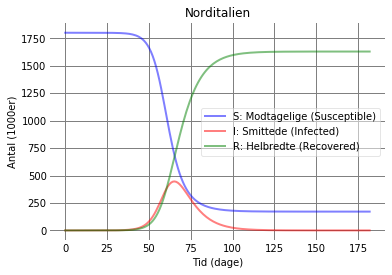

In [120]:
S,I,R = sir_prognose(angrebsrate=0.10, sir_parametre=NORDITALIEN_PARAMETRE)
ax = plot_sir(NORDITALIEN_PARAMETRE, t, S, I, R)
plt.show(ax)

Hvis vi plotter for Danmark med den nye 1,4 smitterate tager det lang tid at komme gennem bølgen:

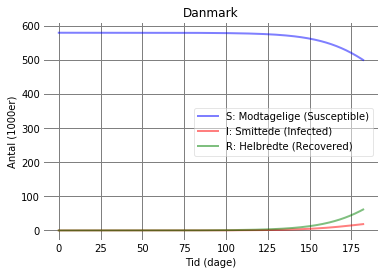

In [122]:
# Danske forhold
beta_dk = 1.4 * gamma  
DANMARK_PARAMETRE = SIRParametre('Danmark', BEFOLKNINGSTAL_DANMARK, beta_dk, gamma)

S,I,R = sir_prognose(angrebsrate=0.1, sir_parametre=DANMARK_PARAMETRE)
ax = plot_sir(DANMARK_PARAMETRE, t, S, I, R)
plt.show(ax)


Der er således brug for at kunne skifte beta undervejs, da den startede på $2,6 \gamma$ og nu er faldet til $1,4\gamma$.

  


